In [4]:
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase

import numpy as np
import matplotlib.pyplot as plt

In [5]:
#Quad Copter Model

A = torch.tensor([
    [1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0., 0.],
    [0., 0., 1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0.],
    [0.0488, 0., 0., 1., 0., 0., 0.0016, 0., 0., 0.0992, 0., 0.],
    [0., -0.0488, 0., 0., 1., 0., 0., -0.0016, 0., 0., 0.0992, 0.],
    [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.0992],
    [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
    [0.9734, 0., 0., 0., 0., 0., 0.0488, 0., 0., 0.9846, 0., 0.],
    [0., -0.9734, 0., 0., 0., 0., 0., -0.0488, 0., 0., 0.9846, 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.9846]
])
B = torch.tensor([
    [0., -0.0726, 0., 0.0726],
    [-0.0726, 0., 0.0726, 0.],
    [-0.0152, 0.0152, -0.0152, 0.0152],
    [-0., -0.0006, -0., 0.0006],
    [0.0006, 0., -0.0006, 0.0000],
    [0.0106, 0.0106, 0.0106, 0.0106],
    [0, -1.4512, 0., 1.4512],
    [-1.4512, 0., 1.4512, 0.],
    [-0.3049, 0.3049, -0.3049, 0.3049],
    [-0., -0.0236, 0., 0.0236],
    [0.0236, 0., -0.0236, 0.],
    [0.2107, 0.2107, 0.2107, 0.2107]])


# Constraints
u0 = 10.5916

#control constraints will be enforced by sigmoid activation
umin = torch.tensor([9.6, 9.6, 9.6, 9.6]) - u0
umax = torch.tensor([13., 13., 13., 13.]) - u0

#state constraints will be enforced through penalty methods
#constraints are only present on the first two state variables
xmin = torch.tensor([-np.pi / 6, -np.pi / 6]) 
xmax = torch.tensor([np.pi / 6, np.pi / 6])


# Objective function
Q = torch.diag(torch.tensor([0., 0., 10., 10., 10., 10., 0., 0., 0., 5., 5., 5.]))
R = 0.1 * torch.eye(4)


# reference states
#xr = torch.tensor([0, 0., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0.]) #reference point to control to.
xr = torch.tensor([0, 0., 0, 0, 0, 0., 0., 0., 0., 0., 0., 0.]) #reference point to control to.

# Prediction horizon
N = 10



[nx, nu] = B.shape
n_horizon = N


# neural control policy
mlp = blocks.MLP(nx, nu*n_horizon, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[100, 100, 100, 100])
open_loop_policy = Node(mlp, ['X'], ['U_open_loop'], name='open_loop_policy')
policy_map = lambda OL_U : umin + torch.sigmoid(torch.reshape(OL_U,(OL_U.shape[0],n_horizon,nu)))*(umax - umin)
policy_buffer = Node(policy_map,['U_open_loop'],['U_open_loop_buffer'],name = 'policy_buffer')



# linear state space model
xnext = lambda x, u: x @ A.T + u @ B.T    
one_step_dynamics = Node(xnext, ['X', 'U_open_loop_buffer'], ['X'], name='integrator')
ol_system = System([one_step_dynamics])
ol_system.nsteps = n_horizon
#ol_system.show()


In [6]:
# Training dataset generation
angle_scale = 1.0
state_scale = 0.8
x0min = np.array([-angle_scale*np.pi/6, -angle_scale*np.pi/6, -state_scale*1., -state_scale*1., -state_scale*1., -state_scale*1., -state_scale*1., -state_scale*1., -state_scale*1., -state_scale*1., -state_scale*1., -state_scale*1.])
x0max = np.array([angle_scale*np.pi/6, angle_scale*np.pi/6, state_scale*1., state_scale*1., state_scale*1., state_scale*1., state_scale*1., state_scale*1., state_scale*1., state_scale*1., state_scale*1., state_scale*1.])

train_samples = 5000
dev_samples = 100
BATCH_SIZE = 100


train_data = DictDataset({'X':torch.unsqueeze(torch.tensor(np.random.uniform(low = x0min, high = x0max,size = (train_samples,len(x0min))),dtype = torch.float32),1)}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'X': torch.unsqueeze(torch.tensor(np.random.uniform(low = x0min, high = x0max,size = (dev_samples,len(x0min))),dtype = torch.float32),1)}, name='dev')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=BATCH_SIZE,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

In [7]:
# td = next(iter(train_loader))
# dd = open_loop_policy(td)
# td = dict(td,**dd)
# dd = policy_buffer(td)
# td = dict(td,**dd)
# dd = ol_system(td)
# td = dict(td,**dd)

In [8]:
# Define optimization problem
u = variable('U_open_loop_buffer')
x = variable('X')

f =  torch.sum((x-xr)*(x - xr)*torch.diag(Q)) + torch.sum(u*u*torch.diag(R))
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]



state_upper_bound_penalty = 100.0*(x[:,:,0:2]<xmax)
state_lower_bound_penalty = 100.0*(x[:,:,0:2]>xmax)

constraints = [state_upper_bound_penalty, state_lower_bound_penalty]



loss = PenaltyLoss(objectives, constraints)
problem = Problem([open_loop_policy,policy_buffer,ol_system], loss)
optimizer = torch.optim.AdamW(open_loop_policy.parameters(), lr=0.001)

In [9]:
#problem.show()

In [10]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=optimizer,
    epochs=1000,
    train_metric="train_loss",
    dev_metric="dev_loss",
    eval_metric='dev_loss',
    warmup=400,
)


best_model = trainer.train()

epoch: 0  train_loss: 77580.140625
epoch: 1  train_loss: 19929.2578125
epoch: 2  train_loss: 16170.0673828125
epoch: 3  train_loss: 14043.330078125
epoch: 4  train_loss: 13554.298828125
epoch: 5  train_loss: 12867.73046875
epoch: 6  train_loss: 12356.7177734375
epoch: 7  train_loss: 11702.1025390625
epoch: 8  train_loss: 11265.375
epoch: 9  train_loss: 10437.0771484375
epoch: 10  train_loss: 10342.7529296875
epoch: 11  train_loss: 10415.31640625
epoch: 12  train_loss: 9936.0947265625
epoch: 13  train_loss: 9594.9150390625
epoch: 14  train_loss: 9477.7177734375
epoch: 15  train_loss: 9297.1796875
epoch: 16  train_loss: 9401.333984375
epoch: 17  train_loss: 9938.1884765625
epoch: 18  train_loss: 9767.44921875
epoch: 19  train_loss: 9299.9609375
epoch: 20  train_loss: 9131.0771484375
epoch: 21  train_loss: 8937.4189453125
epoch: 22  train_loss: 9106.494140625
epoch: 23  train_loss: 9000.6474609375
epoch: 24  train_loss: 9041.4990234375
epoch: 25  train_loss: 8920.0068359375
epoch: 26  tra

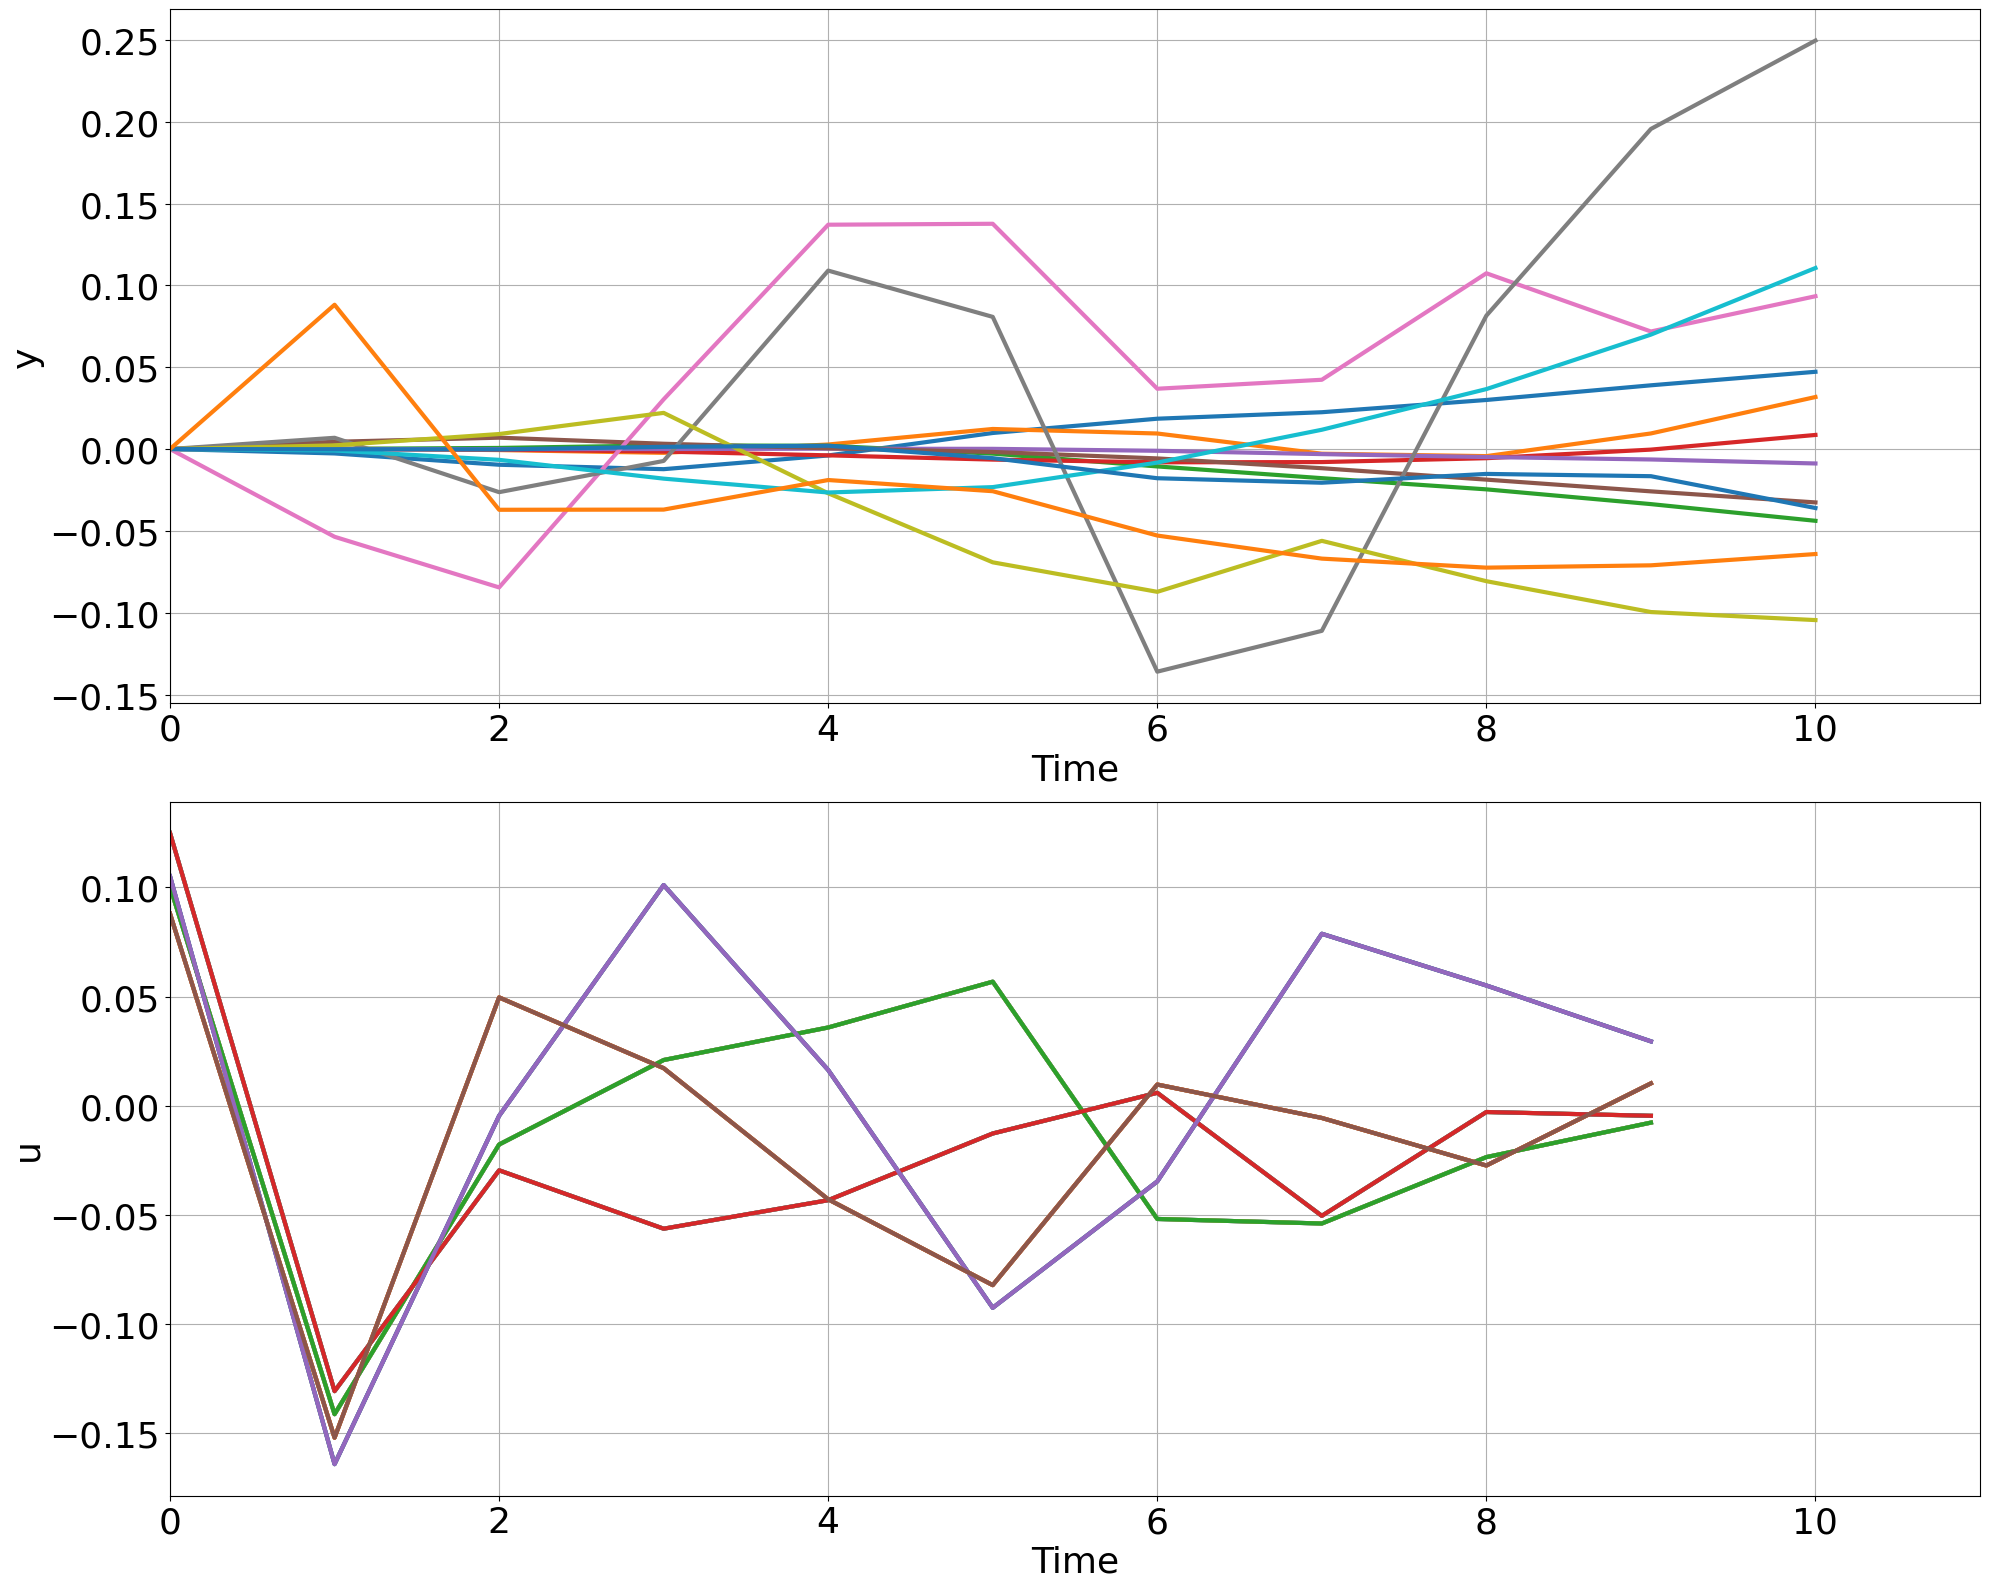

In [11]:
# Test best model 
problem.load_state_dict(best_model)
data = {'X': torch.zeros(1, 1, nx, dtype=torch.float32)}
nsteps = n_horizon
#nsteps = 30
#cl_system.nsteps = nsteps
dat = open_loop_policy(data)
data = dict(data,**dat)
dat = policy_buffer(data)
data = dict(data,**dat)
trajectories = ol_system(data)
pltCL(Y=trajectories['X'].detach().numpy().reshape(nsteps+1, nx), U=trajectories['U_open_loop_buffer'].detach().numpy().reshape(nsteps, nu), figname='cl.png')


In [12]:
''' 
Construct DR Correction
'''

''' 
Will assume that variable x is of form

[n_dim*(n_horizon + 1),u_dim*n_horizon,slacks]
'''

Q_x = Q
Q_u = R

'''
# DEFINE THE OBJECTIVE
'''
# x is assumed to include slack variables!
#def f_obj(x,p):
#    x_time = torch.reshape(x[:nx*(n_horizon+1)],(n_horizon+1,nx))
#    u_time = torch.reshape(x[nx*(n_horizon+1):nx*(n_horizon+1) + nu*n_horizon],(n_horizon,nu))
#    return torch.sum(x_time*torch.squeeze(torch.matmul(Q_x,torch.unsqueeze(x_time,-1)))) + torch.sum(u_time*torch.squeeze(torch.matmul(Q_u,torch.unsqueeze(u_time,-1))))


def f_obj(x,p):
    x_time = torch.reshape(x[nx:nx*(n_horizon+1)],(n_horizon,nx))
    u_time = torch.reshape(x[nx*(n_horizon+1):nx*(n_horizon+1) + nu*n_horizon],(n_horizon,nu))
    return torch.sum((x_time-xr)*torch.squeeze(torch.matmul(Q_x,torch.unsqueeze((x_time-xr),-1)))) + torch.sum(u_time*torch.squeeze(torch.matmul(Q_u,torch.unsqueeze(u_time,-1))))


'''
# DEFINE THE CONSTRAINTS
'''

def F_ineq(x,p):
    x_time = torch.reshape(x[:nx*(n_horizon+1)],(n_horizon+1,nx))
    x_angle_time = x_time[:,0:2]
    xat_lower_bound = torch.ravel(xmin - x_angle_time)
    xat_upper_bound = torch.ravel(x_angle_time - xmax)
    u_time = torch.reshape(x[nx*(n_horizon+1):nx*(n_horizon+1) + nu*n_horizon],(n_horizon,nu))
    u_lower_bound = torch.ravel(umin - u_time)
    u_upper_bound = torch.ravel(u_time - umax)
    return torch.cat((xat_lower_bound,xat_upper_bound,u_lower_bound,u_upper_bound))


def F_eq(x,p):
    x_time = torch.reshape(x[:nx*(n_horizon+1)],(n_horizon+1,nx))
    x_time_r = x_time[0:-1,:]
    x_time_f = x_time[1:,:]
    u_time = torch.reshape(x[nx*(n_horizon+1):nx*(n_horizon+1) + nu*n_horizon],(n_horizon,nu))
    initial_condition = x_time[0,:] - p
    dyn_time = torch.squeeze(torch.matmul(A,torch.unsqueeze(x_time_r,-1))) + torch.squeeze(torch.matmul(B,torch.unsqueeze(u_time,-1))) - x_time_f
    dyn = torch.ravel(dyn_time)
    return torch.cat((initial_condition,dyn))



In [13]:
import sys
sys.path.append('../New_Experiments')


import DRSolver as dr
from importlib import reload

reload(dr)



num_steps = 60 # number of DR iterations to take
initial_steps = 0
x_dim = nx*(n_horizon + 1) + nu*n_horizon # dimension of primal variable
n_ineq = 4*(n_horizon + 1) + 2*nu*n_horizon  #number of inequality constraints
n_eq = nx*(n_horizon + 1) #number of equality constraints
parm_dim = nx #number of problem parameters
order = 'second' # What order approximation of the objective to use {'first', 'second'}
project_fixedpt = False
#metric scaling parameters
initial_lb_P = 1e-1
initial_ub_P = 1e1
#initial_lb_P = 1/2
#initial_ub_P = 2
lb_P = 1e-3
ub_P = 10.0
scl_lb_P = 0.05
scl_ub_P = 0.8
#lb_P = 1.0/100.0
#ub_P = 1.0
#scl_lb_P = 0.01
#scl_ub_P = 10.0
solver = dr.DRSolverFast(
    f_obj = f_obj,
    F_ineq = F_ineq,
    F_eq = F_eq,
    x_dim = x_dim, 
    n_ineq = n_ineq,
    n_eq = n_eq, 
    order = order,
    JF_fixed=True,
    parm_dim = parm_dim,
    num_steps = num_steps,
    initial_steps= initial_steps,
    initial_lb_P=initial_lb_P,
    initial_ub_P = initial_ub_P,
    lb_P = lb_P,
    ub_P = ub_P,
    scl_lb_P = scl_lb_P,
    scl_ub_P = scl_ub_P,
    project_fixedpt=project_fixedpt
    )





# REMAP THROUGH DR CORRECTION

def dr_map(x,u):
    x_init = x[:,0,:]
    x_cat = torch.reshape(x,(x.shape[0],nx*(n_horizon + 1)))
    u_cat = torch.reshape(u,(u.shape[0],nu*n_horizon))
    return torch.cat((x_cat,u_cat),dim = -1), x_init

dr_mapper = Node(dr_map,['X','U_open_loop_buffer'],['X0_primal','p'],name = 'dr_mapper')
DR_correction = Node(solver,['X0_primal','p'],['X_corrected','cnv_gap','X_hist'])



components = [open_loop_policy,policy_buffer,ol_system,dr_mapper, DR_correction]



## ADD A CONVERGENCE PENALTY
cnv_gap = variable("cnv_gap")
f_cnv = (cnv_gap)**2
cnv_obj = f_cnv.minimize(weight=1e8, name='cnv_obj')
objectives = [cnv_obj]
constraints = []



#create loss function
loss = PenaltyLoss(objectives, constraints)
#construct constrained optimization problem
problem = Problem(components, loss)



In [14]:

'''
#######################################
#######################################

Train DR correction layer

#######################################
########################################
'''

DR_train_epochs = 40
optimizer = torch.optim.AdamW(solver.parameters(), lr=1e-3)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer,
    epochs=DR_train_epochs,
    patience=500,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

# Train solution map
best_model = trainer.train()


epoch: 0  train_loss: 321.1822204589844
epoch: 1  train_loss: 62.608245849609375
Interrupted training loop.


In [12]:
#solver.num_steps = 40

# EVAULATE DR OUTPUTS ON DEV SET

In [18]:
td = next(iter(dev_loader))
td = problem(td)

x_corrected = td['dev_X_corrected']
x_time = torch.reshape(x_corrected[:,:nx*(n_horizon+1)],(x_corrected.shape[0],n_horizon+1,nx))
u_time = torch.reshape(x_corrected[:,nx*(n_horizon+1):nx*(n_horizon+1) + nu*n_horizon],(x_corrected.shape[0],n_horizon,nu))


In [13]:

#td = {'X': torch.zeros(1, 1, nx, dtype=torch.float32)}
#td = next(iter(dev_loader))
#dd = open_loop_policy(td)
#td = dict(td,**dd)
#dd = policy_buffer(td)
#td = dict(td,**dd)
#dd = ol_system(td)
#td = dict(td,**dd)
#dd = dr_mapper(td)
#td = dict(td,**dd)

#dd = DR_correction(td)
#td = dict(td,**dd)

# COMPUTE TRAJECTORY FROM CONTROL

In [19]:
# we take the control trajectory from the solver (batch,time step, control_dim)

u_solver = u_time

#we take the initial state trajectory, (batch,1, n_dim)
x_initial = x_time[:,0,None,:]


#we pass through the dynamics to construct state trajectory
xnext = lambda z, w: z @ A.T + w @ B.T    

def Dynamics_solution(x_initial,u_sol):
    n_steps = u_sol.shape[1]
    x_n = x_initial
    x_traj = x_initial
    for i in range(n_steps):
        xnew = xnext(x_n,u_sol[:,i,None,:])
        x_n = xnew
        x_traj = torch.cat((x_traj,xnew),dim = 1)
    return x_traj
x_traj = Dynamics_solution(x_initial,u_solver)

In [20]:
x_traj.shape

torch.Size([100, 11, 12])

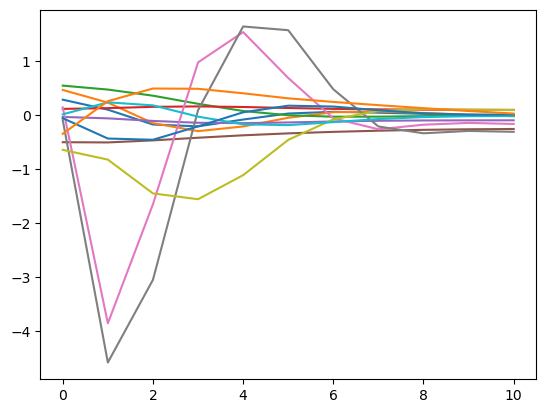

In [21]:
import matplotlib.pyplot as plt
plt.plot(x_traj[0,:,:].detach().numpy())

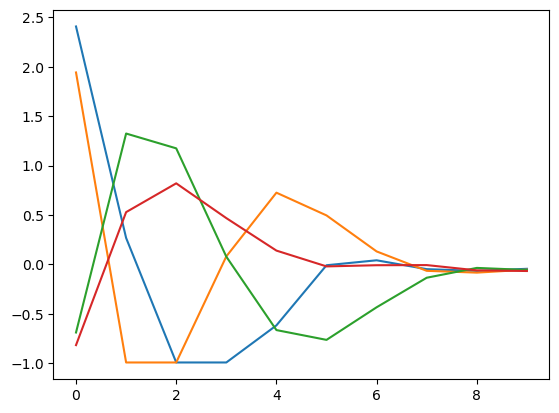

In [22]:
plt.plot(u_time[0,:,:].detach().numpy())

In [26]:
''' 
Check CVXPY
'''


import cvxpy as cv
import numpy as np
import scipy as sp
from scipy import sparse
from pylab import *
import time

# Discrete time model of a quadcopter
Ad = sparse.csc_matrix([
    [1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0., 0.],
    [0., 0., 1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0.],
    [0.0488, 0., 0., 1., 0., 0., 0.0016, 0., 0., 0.0992, 0., 0.],
    [0., -0.0488, 0., 0., 1., 0., 0., -0.0016, 0., 0., 0.0992, 0.],
    [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.0992],
    [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
    [0.9734, 0., 0., 0., 0., 0., 0.0488, 0., 0., 0.9846, 0., 0.],
    [0., -0.9734, 0., 0., 0., 0., 0., -0.0488, 0., 0., 0.9846, 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.9846]
])
Bd = sparse.csc_matrix([
    [0., -0.0726, 0., 0.0726],
    [-0.0726, 0., 0.0726, 0.],
    [-0.0152, 0.0152, -0.0152, 0.0152],
    [-0., -0.0006, -0., 0.0006],
    [0.0006, 0., -0.0006, 0.0000],
    [0.0106, 0.0106, 0.0106, 0.0106],
    [0, -1.4512, 0., 1.4512],
    [-1.4512, 0., 1.4512, 0.],
    [-0.3049, 0.3049, -0.3049, 0.3049],
    [-0., -0.0236, 0., 0.0236],
    [0.0236, 0., -0.0236, 0.],
    [0.2107, 0.2107, 0.2107, 0.2107]])
[nx, nu] = Bd.shape

# Constraints
u0 = 10.5916
uminc = np.array([9.6, 9.6, 9.6, 9.6]) - u0
umaxc = np.array([13., 13., 13., 13.]) - u0
xminc = np.array([-np.pi / 6, -np.pi / 6, -np.inf, -np.inf, -np.inf, -1.,
                 -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf])
xmaxc = np.array([np.pi / 6, np.pi / 6, np.inf, np.inf, np.inf, np.inf,
                 np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])

# Objective function
Qs = sparse.diags([0., 0., 10., 10., 10., 10., 0., 0., 0., 5., 5., 5.])
QNs = Qs
Rs = 0.1 * sparse.eye(4)

# Initial and reference states
#xrc = np.array([0, 0., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0.])
xrc = np.array([0, 0., 0, 0, 0, 0., 0., 0., 0., 0., 0., 0.])

# Prediction horizon
N = n_horizon

# Define problem
uc = cv.Variable((nu, N))
xc = cv.Variable((nx, N + 1))
x_init = cv.Parameter(nx)
objectivec = 0
constraintsc = [xc[:, 0] == x_init]
for k in range(N):
    objectivec += cv.quad_form(xc[:, k] - xrc, Qs) + cv.quad_form(uc[:, k], Rs)
    constraintsc += [xc[:, k + 1] == Ad @ xc[:, k] + Bd @ uc[:, k]]
    constraintsc += [ xc[:, k]>=xminc, xc[:, k] <= xmaxc]
    constraintsc += [uminc <= uc[:, k], uc[:, k] <= umaxc]
constraintsc +=[ xc[:, k+1]>=xminc, xc[:, k+1] <= xmaxc]
objectivec += cv.quad_form(xc[:, N] - xrc, QNs)
prob = cv.Problem(cv.Minimize(objectivec), constraintsc)



'''
Solve single instance
'''

# x0min = np.array([-np.pi/6, -np.pi/6, -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])
# x0max = np.array([np.pi/6, np.pi/6, 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
# x0 = np.random.uniform(low = x0min, high = x0max)
# #x0 = np.array([0.5, -0.5, -1., -1., 0., 0., 0., 0., 0., 0., 0., 0.])

#x0 = np.zeros(nx)

#x_init.value = x0
#prob.solve(solver=cv.OSQP, warm_start=True,verbose = True)



'''
Solve Loop
'''

# x0min = np.array([-np.pi/6, -np.pi/6, -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])
# x0max = np.array([np.pi/6, np.pi/6, 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
# x0 = np.random.uniform(low = x0min, high = x0max)
# #x0 = np.array([0.5, -0.5, -1., -1., 0., 0., 0., 0., 0., 0., 0., 0.])

#x0 = np.zeros(nx)

td = next(iter(dev_loader))
X_inits = td['X'].detach().numpy()
X_cv_sols = []
U_cv_sols = []
for i in range(X_inits.shape[0]):
    x0 = np.ravel(X_inits[i,:,:])
    x_init.value = x0
    prob.solve(solver=cv.OSQP, warm_start=True,verbose = True)
    X_cv_sols.append( np.transpose(xc.value) )
    U_cv_sols.append( np.transpose(uc.value) )

X_cv_sols = np.stack(X_cv_sols)
U_cv_sols = np.stack(U_cv_sols)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Mar 12 02:28:04 PM: Your problem has 172 variables, 53 constraints, and 12 parameters.
(CVXPY) Mar 12 02:28:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 12 02:28:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 12 02:28:04 PM: Compiling problem (target solver=OSQP).
(CVXPY) Mar 12 02:28:04 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Mar 12 02:28:04 PM: Applying reduction CvxAttr2Constr
(CVXPY) Mar 12 02:28:04 PM: Applying reduction Qp2Symbolic

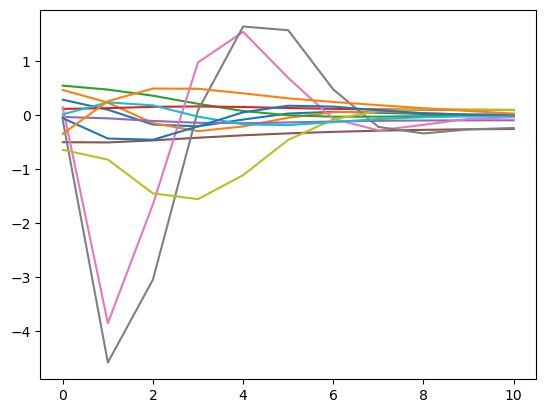

In [29]:
plt.plot(X_cv_sols[0,:,:])

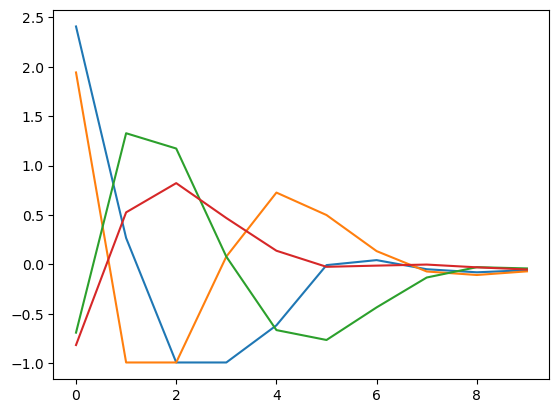

In [30]:
plt.plot(U_cv_sols[0,:,:])

In [37]:
''' 
Compute difference
'''

xdr = x_time.detach().numpy()
udr = u_time.detach().numpy()


print('Mean relative difference in state traj: ', np.mean(np.sum( np.sum((xdr - X_cv_sols)**2,axis = 2),axis = 1 )/ (np.sum(np.sum(X_cv_sols**2,axis = 2),axis = 1) )) )


print('Mean relative difference in controls: ', np.mean(np.sum( np.sum((udr - U_cv_sols)**2,axis = 2),axis = 1 )/ (np.sum(np.sum(U_cv_sols**2,axis = 2),axis = 1) )) )


Mean relative difference in state traj:  0.004344358622914221
Mean relative difference in controls:  0.0020085450585890807
